In [1]:
import numpy as np
import pandas as pd
import os
import io
import seaborn as sns
import requests
import json

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy
import scipy.stats as stats
import scipy.optimize as opt
#import statsmodels.api as sm

from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated, Mixture
import theano.tensor as tt 
from pymc3.distributions.distribution import Continuous, draw_values, generate_samples

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
plt.style.use('seaborn-darkgrid')
pd.set_option('display.max_columns', 500)
%matplotlib inline 

import pickle

In [2]:
data = pd.read_csv("data/combined_seasons.csv")

In [3]:
hurricanes = data[(data['GameType'] == 'R') & (data['Event_Type_ID'] == 'GOAL') & (data['EmptyNet'] != 'True') & (data['Period'] != 4) & (data['Period'] != 5) & ((data['Away'] == 'Carolina Hurricanes') | (data['Home'] == 'Carolina Hurricanes'))].reset_index()

In [4]:
canes_games = hurricanes[['Event_Type_ID', 'Home', 'Away', 'Period', 'GameID', 'Event_Team', 'GameDate', 'Season','Final_Away_Score', 'Final_Home_Score']]

In [5]:
canes_games['Opponent'] = canes_games['Event_Team'].apply(lambda x: x if x == 'Carolina Hurricanes' else 'Opponent')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
grouped = canes_games[['GameID', 'Opponent', 'Period']].groupby(['GameID', 'Opponent']).count().reset_index()
grouped = grouped.groupby(['GameID', 'Opponent'])['Period'].aggregate('mean').unstack().reset_index().fillna(0)
game_info = canes_games[['GameID', 'Final_Away_Score', 'Final_Home_Score', 'Home', 'Away', 'GameDate', 'Season']].drop_duplicates()
game_data = game_info.merge(grouped, on='GameID', how='inner')
game_data['GoalDiff'] = game_data['Carolina Hurricanes'] - game_data['Opponent']

In [7]:
df_2019 = game_data[game_data['Season'] == '2018-2019'].reset_index()

In [8]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    
    return Interpolated(param, x, y)

def prob_persona_faster(persona, personb):
    return np.float(sum(np.array(persona) - np.array(personb) > 0))/len(personb)

In [9]:
#Load the Trace from Running the 2017-2018 Season
with open('20172018_trace', 'rb') as handle:
    trace = pickle.load(handle)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fe18368d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5fe17972b0>]], dtype=object)

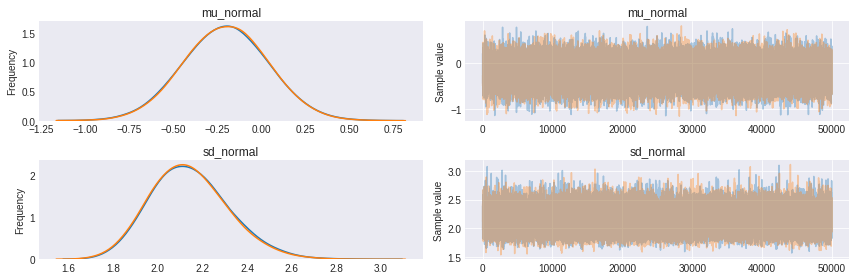

In [10]:
#Check the Load
pm.traceplot(trace)

In [11]:
#Load Previously Run Probabilities
prev_run = pd.read_csv("canes.csv")
probabilities = prev_run['Probabilities'].tolist()

In [16]:
for i in range(len(probabilities), len(df_2019)):
    observed = df_2019[0:i+1]['GoalDiff'].values
    cont = True
    while cont == True:
        try:
            with pm.Model() as model:
                #Pooled Parameters
                mu_normal = from_posterior('mu_normal', trace['mu_normal'])
                sd_normal = from_posterior('sd_normal', trace['sd_normal'])

                likelihood = pm.Normal('likelihood', mu=mu_normal, sd=sd_normal, observed=observed)

                trace2 = pm.sample(50000, cores=-1, tune=2500)
                
            probabilities.append(prob_persona_faster(trace2.get_values('mu_normal'), trace.get_values('mu_normal')))
            print(probabilities)
            cont = False
        except:
            pass

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:22<00:00, 633.77it/s]


[0.5030100000000001, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.5525899999999999, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46971999999999997, 0.48658999999999997, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43573999999999996, 0.44128999999999996, 0.48136999999999996, 0.45873, 0.42378000000000005, 0.45098, 0.44271000000000005, 0.43403, 0.46233, 0.48589, 0.5030600000000001, 0.51586, 0.52788]


In [17]:
df_2019['Probability'] = probabilities

In [18]:
df_2019['OpposingTeam'] = df_2019.apply(lambda row: row['Home'] if row['Home'] != 'Carolina Hurricanes' else row['Away'], axis=1)
df_2019['Opponent2'] =  pd.to_datetime(df_2019['GameDate']).dt.strftime("%b %d") + " \n " + df_2019['OpposingTeam']

[ 0.       0.50301]
[ 1.       0.53354]
[ 2.       0.56934]
[ 3.       0.60035]
[ 4.       0.60159]
[ 5.       0.58913]
[ 6.       0.58098]
[ 7.       0.55259]
[ 8.       0.56777]
[ 9.      0.5742]
[ 10.        0.56199]
[ 11.        0.54905]
[ 12.        0.55437]
[ 13.        0.51083]
[ 14.        0.48468]
[ 15.        0.50359]
[ 16.        0.50489]
[ 17.        0.51031]
[ 18.        0.46972]
[ 19.        0.48659]
[ 20.        0.50145]
[ 21.        0.53486]
[ 22.        0.49832]
[ 23.        0.50977]
[ 24.        0.51321]
[ 25.        0.50367]
[ 26.        0.45415]
[ 27.        0.48139]
[ 28.        0.44593]
[ 29.        0.43574]
[ 30.        0.44129]
[ 31.        0.48137]
[ 32.        0.45873]
[ 33.        0.42378]
[ 34.        0.45098]
[ 35.        0.44271]
[ 36.        0.43403]
[ 37.        0.46233]
[ 38.        0.48589]
[ 39.        0.50306]
[ 40.        0.51586]
[ 41.        0.52788]


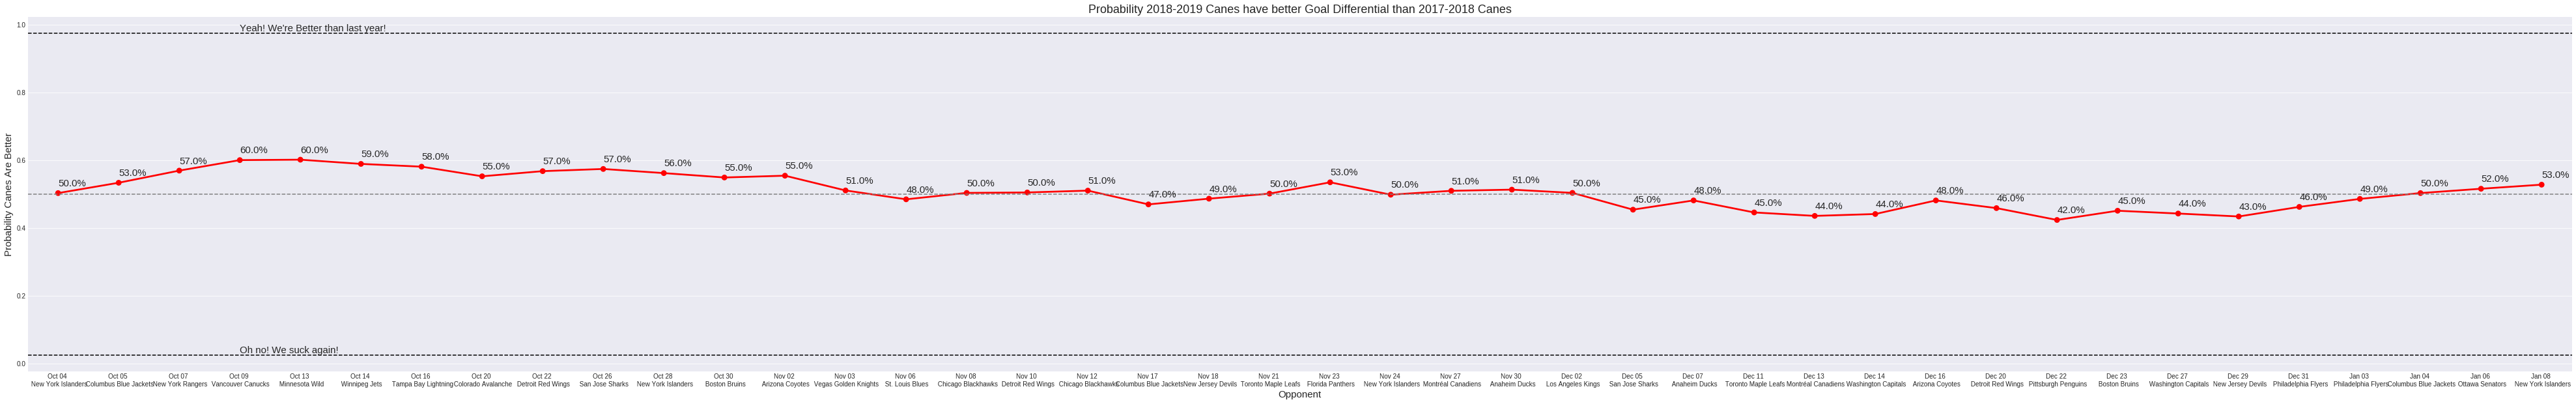

In [19]:
fig, ax = plt.subplots(figsize=(70, 10))
ax.set_title('Probability 2018-2019 Canes have better Goal Differential than 2017-2018 Canes', fontsize=18)
p1 = sns.pointplot(x=df_2019['Opponent2'], y=df_2019['Probability'], color='red')
plt.axhline(.975, color='black', ls='--', label= "Yeah! We're Better than Last Year!")
plt.axhline(.025, color='black', ls='--', label= "Nope We Suck")
plt.axhline(.50, color='grey', ls='--')
p1.set_ylabel('Probability Canes Are Better', fontsize=15)
p1.set_xlabel('Opponent', fontsize=15)
for c in ax.collections:
    for of in c.get_offsets():
        print(of)
        of2 = [of[0], of[1]+0.02]
        ax.annotate('%r' % round(of[1]*100, 0) + "%", of2, size=15)
ax.annotate("Yeah! We're Better than last year!", [3, .98], size=15)
ax.annotate("Oh no! We suck again!", [3, .03], size=15)
plt.show()

In [20]:
df_2019.to_csv("canes.csv")